In [1]:
import os
import glob
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "data/multi_resolution"   
SEQ_LEN = 64

FEATURE_COLS = ["open", "high", "low", "close", "r"]  # no volume

CLASSES = [
  'BearBat','BearButterfly','BearCrab','BearCypher','BearGartley','BearShark',
  'BullBat','BullButterfly','BullCrab','BullCypher','BullGartley','BullShark'
]
class_to_id = {c:i for i,c in enumerate(CLASSES)}
num_classes = len(CLASSES)

# Limit how many sequences per file to avoid super long training
MAX_SEQS_PER_FILE = None  # set None for unlimited
MIN_GROUP_LEN = 1         # keep 1, because we pad to SEQ_LEN anyway


In [3]:
files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
print("Found files:", len(files))
print(*files[:20], sep="\n")

Found files: 17
data/multi_resolution\1day_sigma0.01.csv
data/multi_resolution\1day_sigma0.02.csv
data/multi_resolution\1day_sigma0.05.csv
data/multi_resolution\1day_sigma0.07.csv
data/multi_resolution\1day_sigma0.1.csv
data/multi_resolution\1hour_sigma0.005.csv
data/multi_resolution\1hour_sigma0.01.csv
data/multi_resolution\1hour_sigma0.02.csv
data/multi_resolution\1hour_sigma0.05.csv
data/multi_resolution\1minute_sigma0.001.csv
data/multi_resolution\1minute_sigma0.002.csv
data/multi_resolution\1minute_sigma0.005.csv
data/multi_resolution\1minute_sigma0.01.csv
data/multi_resolution\4hours_sigma0.005.csv
data/multi_resolution\4hours_sigma0.01.csv
data/multi_resolution\4hours_sigma0.02.csv
data/multi_resolution\4hours_sigma0.05.csv


In [4]:
JUNK_COLS = {"Unnamed: 0", "Unnamed:0", "index", "level_0"}

REQUIRED_COLS = {"date", "open", "high", "low", "close", "r", "pattern"}

def load_and_clean_csv(path):
    # Read only needed columns if present 
    # We'll read header first to know what exists
    cols = pd.read_csv(path, nrows=0).columns.tolist()
    cols = [c for c in cols if c not in JUNK_COLS]

    # Ensure we include required cols if they exist
    usecols = [c for c in cols if c in REQUIRED_COLS]

    df = pd.read_csv(path, usecols=usecols)

    # Drop junk cols again just in case
    df = df.drop(columns=[c for c in df.columns if c in JUNK_COLS], errors="ignore")

    # Basic column existence check
    missing = REQUIRED_COLS - set(df.columns)
    if missing:
        raise ValueError(f"{os.path.basename(path)} missing columns: {missing}")

    # Parse date
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"])
    df = df.sort_values("date")

    # Ensure pattern is string
    df["pattern"] = df["pattern"].fillna("no-pattern").astype(str)

    # Convert features to numeric
    for c in FEATURE_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Handle NaNs:
    # r NaNs are common -> fill with 0
    df["r"] = df["r"].fillna(0.0)

    # If OHLC are NaN, drop those rows
    df = df.dropna(subset=["open", "high", "low", "close"])

    # Keep only known patterns + no-pattern (filter out typos)
    allowed = set(CLASSES) | {"no-pattern"}
    df = df[df["pattern"].isin(allowed)].copy()

    return df

In [5]:
def df_to_sequences(df):
    # Drop no-pattern for training
    df = df[df["pattern"] != "no-pattern"].copy()
    if len(df) == 0:
        return None, None

    # Group consecutive identical patterns
    df["group_id"] = (df["pattern"] != df["pattern"].shift(1)).cumsum()

    X_list, y_list = [], []

    for _, g in df.groupby("group_id"):
        label = g["pattern"].iloc[0]
        if label not in class_to_id:
            continue

        feat = g[FEATURE_COLS].values.astype(np.float32)

        if len(feat) < MIN_GROUP_LEN:
            continue

        # fixed-length window via pad/truncate
        if len(feat) >= SEQ_LEN:
            seq = feat[-SEQ_LEN:]
        else:
            pad_len = SEQ_LEN - len(feat)
            pad = np.repeat(feat[0:1, :], pad_len, axis=0)
            seq = np.concatenate([pad, feat], axis=0)

        X_list.append(seq)
        y_list.append(class_to_id[label])

        if MAX_SEQS_PER_FILE is not None and len(X_list) >= MAX_SEQS_PER_FILE:
            break

    if len(X_list) == 0:
        return None, None

    X = np.stack(X_list)  # (n_seq, SEQ_LEN, n_feat)
    y = np.array(y_list, dtype=np.int64)
    return X, y


In [6]:
total = Counter()
per_file_counts = {}

for path in files:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        print("No patterns found in:", os.path.basename(path))
        continue
    counts = Counter(y)
    per_file_counts[os.path.basename(path)] = len(y)
    total.update(counts)

print("Total sequences across files:", sum(per_file_counts.values()))
print("Per-file sequences (first 10):", list(per_file_counts.items())[:10])

# Convert total counts to label names
inv = {v:k for k,v in class_to_id.items()}
print("Total label distribution:")
for k,v in total.most_common():
    print(inv[k], v)

Total sequences across files: 347783
Per-file sequences (first 10): [('1day_sigma0.01.csv', 3225), ('1day_sigma0.02.csv', 1453), ('1day_sigma0.05.csv', 370), ('1day_sigma0.07.csv', 229), ('1day_sigma0.1.csv', 117), ('1hour_sigma0.005.csv', 5523), ('1hour_sigma0.01.csv', 3225), ('1hour_sigma0.02.csv', 1453), ('1hour_sigma0.05.csv', 370), ('1minute_sigma0.001.csv', 178282)]
Total label distribution:
BearButterfly 47616
BullButterfly 46145
BearGartley 43593
BullGartley 42532
BearShark 34237
BullShark 33792
BullCypher 18607
BearCypher 17541
BullBat 17082
BullCrab 16480
BearBat 15157
BearCrab 15001


In [7]:
#We use one global scaler for everything
scaler = StandardScaler()

for path in files:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        continue
    scaler.partial_fit(X.reshape(-1, X.shape[-1]))

def scale_X(X):
    s, t, f = X.shape
    X2 = X.reshape(-1, f)
    X2 = scaler.transform(X2)
    return X2.reshape(s, t, f).astype(np.float32)

In [8]:
def dilated_causal_block(x, filters, kernel_size, dilation, dropout=0.0, name=None):
    x = layers.Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        dilation_rate=dilation,
        padding="causal",          # causal conv
        activation=None,
        name=None if name is None else f"{name}_conv_k{kernel_size}_d{dilation}"
    )(x)
    x = layers.ReLU(name=None if name is None else f"{name}_relu_k{kernel_size}_d{dilation}")(x)
    if dropout and dropout > 0:
        x = layers.Dropout(dropout, name=None if name is None else f"{name}_drop_k{kernel_size}_d{dilation}")(x)
    return x

def module_7(x, filters=64, dropout=0.0, name="m7"):
    # Fig.7 (Module(7)): kernel=3, dilation=1 then kernel=3, dilation=2
    x = dilated_causal_block(x, filters, kernel_size=3, dilation=1, dropout=dropout, name=name)
    x = dilated_causal_block(x, filters, kernel_size=3, dilation=2, dropout=dropout, name=name)
    return x

def module_10(x, filters=64, dropout=0.0, name="m10"):
    # Fig.7 (Module(10)): kernel=3 d=1, kernel=3 d=2, kernel=2 d=4
    x = dilated_causal_block(x, filters, kernel_size=3, dilation=1, dropout=dropout, name=name)
    x = dilated_causal_block(x, filters, kernel_size=3, dilation=2, dropout=dropout, name=name)
    x = dilated_causal_block(x, filters, kernel_size=2, dilation=4, dropout=dropout, name=name)
    return x

def module_15(x, filters=64, dropout=0.0, name="m15"):
    # Fig.7 (Module(15)): kernel=3 d=1, kernel=3 d=2, kernel=3 d=4
    x = dilated_causal_block(x, filters, kernel_size=3, dilation=1, dropout=dropout, name=name)
    x = dilated_causal_block(x, filters, kernel_size=3, dilation=2, dropout=dropout, name=name)
    x = dilated_causal_block(x, filters, kernel_size=3, dilation=4, dropout=dropout, name=name)
    return x

def build_liu_si_cnn(seq_len, num_features, num_classes,
                     filters=64, module_dropout=0.0, head_dropout=0.3):
    inp = layers.Input(shape=(seq_len, num_features), name="input")

    b7  = module_7(inp,  filters=filters, dropout=module_dropout, name="module7")
    b10 = module_10(inp, filters=filters, dropout=module_dropout, name="module10")
    b15 = module_15(inp, filters=filters, dropout=module_dropout, name="module15")

    x = layers.Concatenate(name="concat")([b7, b10, b15])

    # Fig.6: MaxPooling1D then 1x1 Conv then Flatten then Softmax
    x = layers.MaxPooling1D(pool_size=2, name="maxpool")(x)

    x = layers.Conv1D(filters=filters, kernel_size=1, padding="same", name="conv1x1")(x)
    x = layers.ReLU(name="conv1x1_relu")(x)

    x = layers.Dropout(head_dropout, name="head_dropout")(x)
    x = layers.Flatten(name="flatten")(x)

    out = layers.Dense(num_classes, activation="softmax", name="softmax")(x)

    model = Model(inp, out, name="LiuSi_1DCNN")
    return model


In [9]:
seq_len = SEQ_LEN
num_features = len(FEATURE_COLS)
num_classes = len(CLASSES)

cnn = build_liu_si_cnn(
    seq_len=seq_len,
    num_features=num_features,
    num_classes=num_classes,
    filters=64,
    module_dropout=0.0,
    head_dropout=0.3
)

cnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn.summary()


Model: "LiuSi_1DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)            │ (None, 64, 5)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_conv_k3_d1 (Conv1D)  │ (None, 64, 64)            │           1,024 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_conv_k3_d1 (Conv1D)  │ (None, 64, 64)            │           1,024 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_relu_k3_d1 (ReLU)    │ (None, 64, 64)            │               0 │ module10_conv_k3_d1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_relu_k3_d1 (ReLU)    │ (None, 64, 64)            │               0 │ module15_conv_k3_d1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module7_conv_k3_d1 (Conv1D)   │ (None, 64, 64)            │           1,024 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_conv_k3_d2 (Conv1D)  │ (None, 64, 64)            │          12,352 │ module10_relu_k3_d1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_conv_k3_d2 (Conv1D)  │ (None, 64, 64)            │          12,352 │ module15_relu_k3_d1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module7_relu_k3_d1 (ReLU)     │ (None, 64, 64)            │               0 │ module7_conv_k3_d1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_relu_k3_d2 (ReLU)    │ (None, 64, 64)            │               0 │ module10_conv_k3_d2[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_relu_k3_d2 (ReLU)    │ (None, 64, 64)            │               0 │ module15_conv_k3_d2[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module7_conv_k3_d2 (Conv1D)   │ (None, 64, 64)            │          12,352 │ module7_relu_k3_d1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_conv_k2_d4 (Conv1D)  │ (None, 64, 64)            │           8,256 │ module10_relu_k3_d2[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_conv_k3_d4 (Conv1D)  │ (None, 64, 64)            │          12,352 │ module15_relu_k3_d2[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module7_relu_k3_d2 (ReLU)     │ (None, 64, 64)            │               0 │ module7_conv_k3_d2[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_relu_k2_d4 (ReLU)    │ (None, 64, 64)            │               0 │ module10_conv_k2_d4[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_relu_k3_d4 (ReLU)    │ (None, 64, 64)            │               0 │ module15_conv_k3_d4[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 97,676 (381.55 KB)

 Trainable params: 97,676 (381.55 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
EPOCHS_PER_FILE = 1
BATCH_SIZE = 64

for epoch in range(5):  # global passes through all files
    np.random.shuffle(files)
    print(f"\n=== Global epoch pass {epoch+1}/5 ===")

    for path in files:
        df = load_and_clean_csv(path)
        X, y = df_to_sequences(df)
        if X is None:
            continue

        X = scale_X(X)

        # shuffle within file
        idx = np.random.permutation(len(X))
        X, y = X[idx], y[idx]

        cnn.fit(X, y, epochs=EPOCHS_PER_FILE, batch_size=BATCH_SIZE, verbose=0)

    print("Done pass", epoch+1)


=== Global epoch pass 1/5 ===
Done pass 1

=== Global epoch pass 2/5 ===
Done pass 2

=== Global epoch pass 3/5 ===
Done pass 3

=== Global epoch pass 4/5 ===
Done pass 4

=== Global epoch pass 5/5 ===
Done pass 5


In [11]:
#The Evaluation Part. Select one from each file type for evaluation

EVAL_FILES = [
    "1hour_sigma0.01.csv",
    "1minute_sigma0.005.csv",
    "1day_sigma0.02.csv"
]

EVAL_FILES = [os.path.join(DATA_DIR, f) for f in EVAL_FILES]

#Build the evaluation dataset
X_eval_list = []
y_eval_list = []

for path in EVAL_FILES:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        continue
    X = scale_X(X)
    X_eval_list.append(X)
    y_eval_list.append(y)

X_eval = np.concatenate(X_eval_list, axis=0)
y_eval = np.concatenate(y_eval_list, axis=0)

print("Evaluation set shape:", X_eval.shape, y_eval.shape)


Evaluation set shape: (38748, 64, 5) (38748,)


In [12]:
#Run cnn predictions
y_probs = cnn.predict(X_eval)
y_pred = np.argmax(y_probs, axis=1)

1211/1211 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [13]:
print(
    classification_report(
        y_eval,
        y_pred,
        labels=np.arange(num_classes),
        target_names=CLASSES,
        zero_division=0
    )
)

               precision    recall  f1-score   support

      BearBat       0.74      0.01      0.02      1470
BearButterfly       0.27      0.79      0.40      5495
     BearCrab       0.76      0.03      0.05      1457
   BearCypher       0.36      0.03      0.06      2081
  BearGartley       0.41      0.40      0.40      4979
    BearShark       0.37      0.09      0.15      3933
      BullBat       0.40      0.03      0.05      1658
BullButterfly       0.30      0.69      0.42      5364
     BullCrab       0.65      0.01      0.02      1635
   BullCypher       0.50      0.02      0.04      2176
  BullGartley       0.42      0.29      0.34      4880
    BullShark       0.47      0.05      0.09      3620

     accuracy                           0.32     38748
    macro avg       0.47      0.20      0.17     38748
 weighted avg       0.41      0.32      0.24     38748



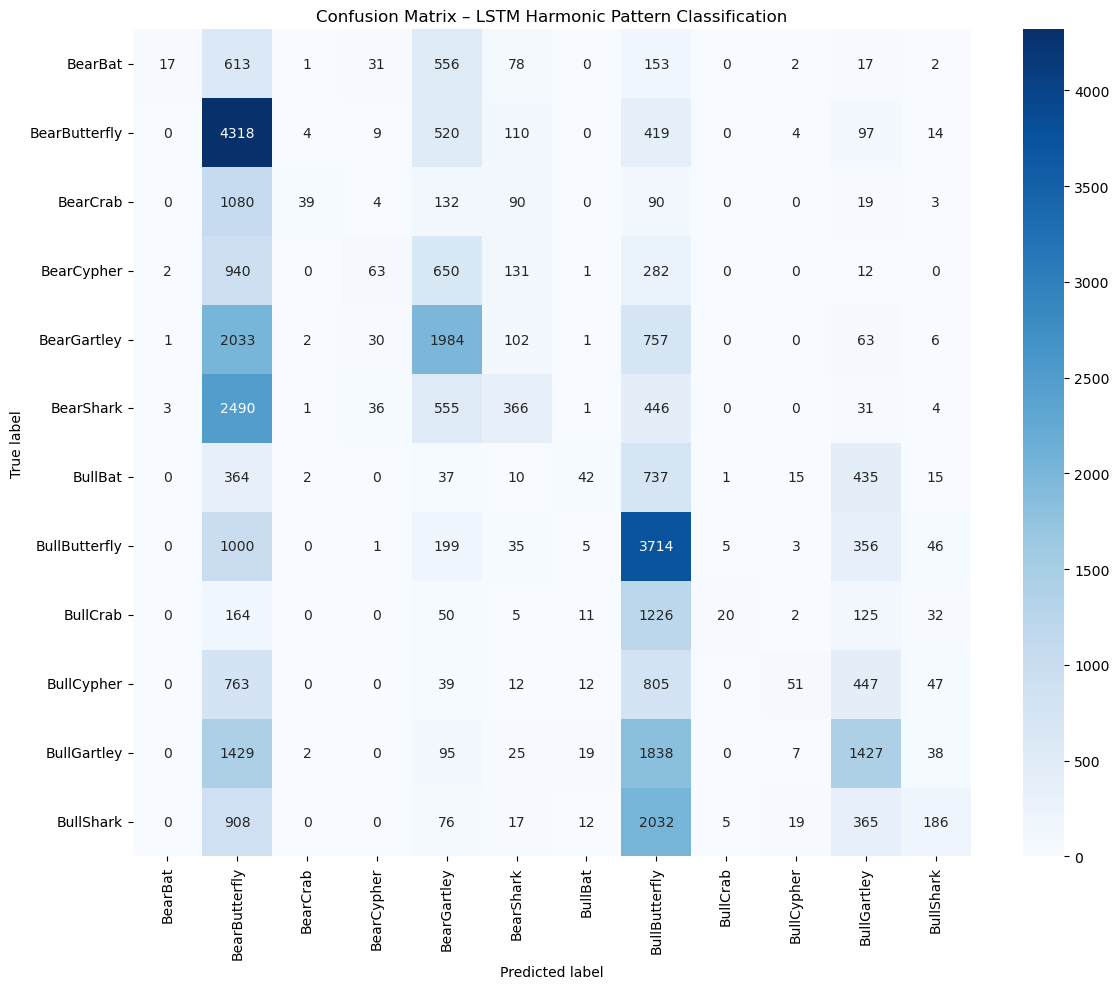

In [14]:
cm = confusion_matrix(
    y_eval,
    y_pred,
    labels=np.arange(num_classes)
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASSES,
    yticklabels=CLASSES
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – LSTM Harmonic Pattern Classification")
plt.tight_layout()
plt.show()